<a href="https://colab.research.google.com/github/leman-cap13/NLP_projects/blob/main/VAD_SER_kapital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vad

In [114]:
!pip install torch torchaudio --quiet

In [115]:
from google.colab import files # test ucun bir ses recordu yuklemek lazimdi 10 15 saniyelik
files.upload()

Saving WhatsApp Audio 2025-07-30 at 17.13.50_f410475a.dat.unknown to WhatsApp Audio 2025-07-30 at 17.13.50_f410475a.dat.unknown


{'WhatsApp Audio 2025-07-30 at 17.13.50_f410475a.dat.unknown': b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00\x00\x01mdat\x00\x00\x00\x00\x00\x04/\x10\x01@"\x80\xa3\x7f\xf8\x85---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------.\xff\xf1\nZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ]\xf9\xa2\x14\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\xb4\x

In [111]:
import torch

model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad', model='silero_vad', force_reload=False)

(get_speech_timestamps, save_audio, read_audio, VADIterator, collect_chunks) = utils


Using cache found in /root/.cache/torch/hub/snakers4_silero-vad_master


In [116]:
import os

original_file = '/content/WhatsApp Audio 2025-07-30 at 17.13.50_f410475a.dat.unknown' # sadece yuklediyim record faylini  adini deyisirem

new_file = '/content/example.wav'

os.rename(original_file, new_file)


In [117]:
wav = read_audio(new_file, sampling_rate=16000)
print(wav.shape)


speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=16000)

speech_audio = collect_chunks(speech_timestamps, wav)



torch.Size([365568])


In [118]:
print(speech_timestamps)


[{'start': 6176, 'end': 38368}, {'start': 54816, 'end': 87008}, {'start': 91168, 'end': 174048}, {'start': 198688, 'end': 251360}, {'start': 269344, 'end': 318432}, {'start': 333856, 'end': 365568}]


In [119]:
save_audio('speech_only.wav', speech_audio, sampling_rate=16000)


files.download('speech_only.wav')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

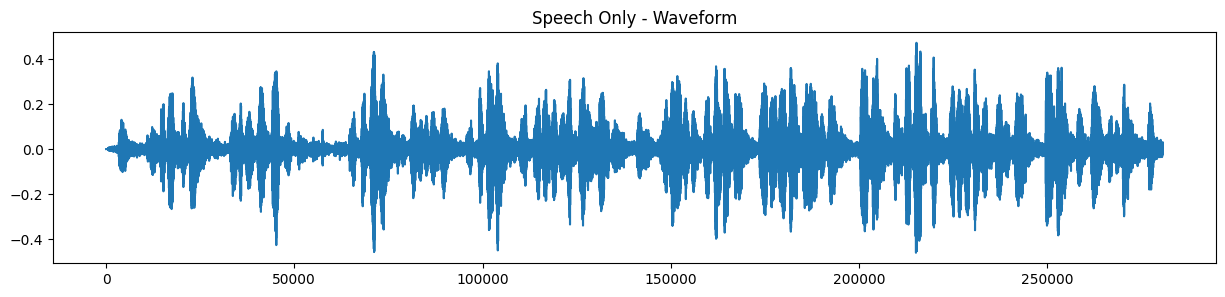

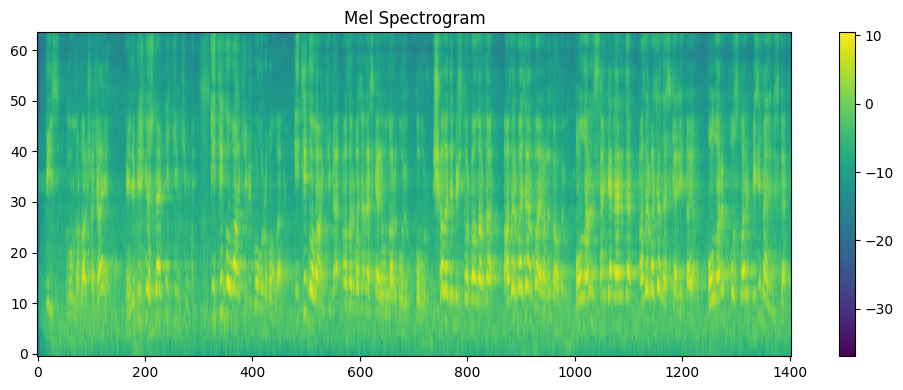

In [120]:
import matplotlib.pyplot as plt
import torchaudio

waveform, sr = torchaudio.load('speech_only.wav')

plt.figure(figsize=(15, 3))
plt.plot(waveform[0].numpy())
plt.title("Speech Only - Waveform")
plt.show()

# Spektroqram
import torchaudio.transforms as T

transform = T.MelSpectrogram(sample_rate=sr, n_mels=64)
mel_spec = transform(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spec[0].log2().numpy(), aspect='auto', origin='lower')
plt.title("Mel Spectrogram")
plt.colorbar()
plt.tight_layout()
plt.show()



The mel spectrogram is a time-frequency representation of audio, where the x-axis is time, the y-axis is frequency (in mel scale), and the color shows the energy at each frequency. It highlights which frequencies are active over time in a way that reflects how humans hear sound. This makes it useful for speech tasks like Voice Activity Detection (VAD) and Speech Emotion Recognition (SER).

In [121]:
print(mel_spec.shape)

torch.Size([1, 64, 1404])


In [122]:
from IPython.display import Audio

Audio('speech_only.wav')


#SpeechBrain SER

In [123]:
!pip install speechbrain --quiet

import torch
from speechbrain.pretrained import EncoderClassifier
from IPython.display import Audio


In [124]:
import speechbrain
import torch

print("SpeechBrain version:", speechbrain.__version__)
print("Torch version:", torch.__version__)


SpeechBrain version: 1.0.3
Torch version: 2.6.0+cu124


In [125]:
signal, fs = torchaudio.load("/content/speech_only.wav")
print(signal.shape)


torch.Size([1, 280736])


In [126]:
# Modeli yüklə
classifier = EncoderClassifier.from_hparams(
    source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP",
    savedir="pretrained_models/emotion_recognition",
    run_opts={"device": "cuda" if torch.cuda.is_available() else "cpu"}
)

# Audio yüklə
signal, fs = torchaudio.load("/content/speech_only.wav")

# Mono yoxla, lazım olsa ortala
if signal.shape[0] > 1:
    signal = signal.mean(dim=0, keepdim=True)

# signal [1, time] formatında olmalıdır
signal = signal.squeeze(0)  # [time]
signal = signal.unsqueeze(0)  # batch əlavə et: [1, time]

print("Input shape:", signal.shape)  # (1, time)

# Move signal to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
signal = signal.to(device)
classifier.to(device) # Ensure the classifier is also on the device

# 1. Wav2Vec2 modulu ilə xüsusiyyət çıxar
features = classifier.mods["wav2vec2"](signal)
print("Features shape:", features.shape)  # [batch, time, feat_dim]

# 2. Statistik pooling
pooled = classifier.mods["avg_pool"](features)
print("Pooled shape:", pooled.shape)  # [batch, feat_dim]

# 3. Linear çıxış
output = classifier.mods["output_mlp"](pooled)
output = output.squeeze(1)  # Bu vacibdir, ölçünü [1, 4] etsin
print("Output shape:", output.shape)  # [1, num_classes]

# 4. Softmax ehtimalları
probabilities = torch.softmax(output, dim=1)
print("Probabilities:", probabilities)


# 5. Ən yaxşı sinfi seç
predicted_index = probabilities.argmax(dim=1)
predicted_label = classifier.hparams.label_encoder.decode_torch(predicted_index)
print(f"Predicted emotion: {predicted_label[0]}")

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Using symlink found at '/content/pretrained_models/emotion_recognition/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/emotion-recognition-wav2vec2-IEMOCAP' if not cached
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in pretrained_models/emotion_recognition.
INFO:speechbrain.utils.fetching:Fetch wav2vec2.ckpt: Using symlink found at '/content/pretrained_models/emotion_recognition/wav2vec2.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path

Input shape: torch.Size([1, 280736])
Features shape: torch.Size([1, 877, 768])
Pooled shape: torch.Size([1, 1, 768])
Output shape: torch.Size([1, 4])
Probabilities: tensor([[1.4562e-11, 1.0000e+00, 1.3446e-12, 2.0750e-13]], device='cuda:0')
Predicted emotion: ang


In [127]:
print("Shape:", probabilities.shape)


Shape: torch.Size([1, 4])


In [128]:
predicted_index = probabilities.argmax(dim=1)
predicted_label = classifier.hparams.label_encoder.decode_torch(predicted_index)
print(f"Predicted emotion: {predicted_label[0]}")


labels_list = list(classifier.hparams.label_encoder.ind2lab.values())


print("Probabilities by class:")

probs_np = probabilities[0].detach().cpu().numpy()
for label, prob in zip(labels_list, probs_np):
    print(f"{label}: {float(prob):.4f}")





Predicted emotion: ang
Probabilities by class:
neu: 0.0000
ang: 1.0000
hap: 0.0000
sad: 0.0000


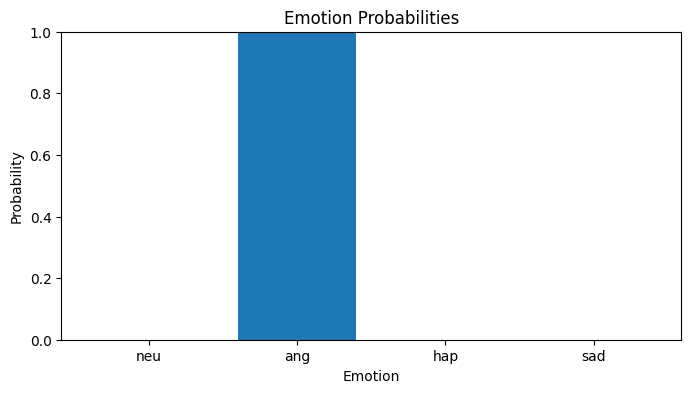

In [129]:
import matplotlib.pyplot as plt
import numpy as np


labels_list = list(classifier.hparams.label_encoder.ind2lab.values())

# The probabilities tensor has shape [1, 1, num_classes].
# We need to reshape it to [num_classes] for plotting.
# Squeeze the first two dimensions and convert to numpy
probs = probabilities.squeeze().cpu().numpy()


plt.figure(figsize=(8, 4))
plt.bar(labels_list, probs)
plt.title("Emotion Probabilities")
plt.ylabel("Probability")
plt.xlabel("Emotion")
plt.ylim(0, 1)
plt.show()

# Gradio interfeys


In [130]:
!pip install gradio torch torchaudio speechbrain --quiet

In [131]:
import gradio as gr
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier

def predict_emotion(audio_path):
    signal, fs = torchaudio.load(audio_path)
    if signal.shape[0] > 1:
        signal = signal.mean(dim=0, keepdim=True)
    signal = signal.squeeze(0).unsqueeze(0).to(device)

    features = classifier.mods["wav2vec2"](signal)
    pooled = classifier.mods["avg_pool"](features)
    output = classifier.mods["output_mlp"](pooled)
    output = output.squeeze(1) if len(output.shape) == 3 else output
    probabilities = torch.softmax(output, dim=1)

    predicted_index = probabilities.argmax(dim=1)
    predicted_label = classifier.hparams.label_encoder.decode_torch(predicted_index)[0]

    labels_list = list(classifier.hparams.label_encoder.ind2lab.values())
    probs = probabilities.detach().cpu().squeeze().numpy()
    probs_dict = {label: float(prob) for label, prob in zip(labels_list, probs)}

    return predicted_label, probs_dict

interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Audio(sources=["microphone", "upload"], type="filepath", label="Danış və ya fayl yüklə"),
    outputs=[
        gr.Text(label="Emosiya"),
        gr.Text(label="Audio məlumatı")
    ],
    title="Speech Emotion Recognition",
    description="Upload a short voice recording to detect the emotion using SpeechBrain's pretrained Wav2Vec2 model.",
    live=False  # bu vacibdir, əgər `live=True` olsa, hər an dəyişir. Submit gözlənilmir.
)

interface.launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29bb394fd42693e340.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [132]:
print("Output:", output)
print("Output shape:", output.shape)
print("Probabilities:", probabilities)
print("Probabilities shape:", probabilities.shape)


Output: tensor([[-2.9923, 21.9603, -5.3747, -7.2433]], device='cuda:0')
Output shape: torch.Size([1, 4])
Probabilities: tensor([[1.4562e-11, 1.0000e+00, 1.3446e-12, 2.0750e-13]], device='cuda:0')
Probabilities shape: torch.Size([1, 4])


#Part 2 Sert Fine Tuning

In [58]:
!wget -q https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip


!unzip -q Audio_Speech_Actors_01-24.zip

import os

audio_dir = "Audio_Speech_Actors_01-24"

file_list = []
for root, dirs, files in os.walk(audio_dir):
    for file in files:
        if file.endswith(".wav"):
            file_list.append(os.path.join(root, file))

print(f"Total files found: {len(file_list)}")
print(file_list[:5])



replace Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Actor_01/03-01-01-01-01-02-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: Total files found: 1440
['Audio_Speech_Actors_01-24/Actor_21/03-01-06-02-02-01-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-07-01-01-02-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-01-01-02-02-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-06-02-02-02-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-08-02-01-02-21.wav']
Sample data entries:
[{'file': 'Audio_Speech_Actors_01-24/Actor_21/03-01-06-02-02-01-21.wav', 'emotion': 'disgust'}, {'file': 'Audio_Speech_Actors_01-24/Actor_21/03-01-07-01-01-02-21.wav', 'emotion': 'surprised'}, {'file': 'Audio_Speech_Actors_01-24/Actor_21/03-01-01-01-02-02-21.wav', 'emotion': 'neutral'}, {'file': 'Audio_Speech_Actors_01-24/Actor_21/03-01-06-02-02-02-21.wav', 'emotion': 'disgust'}, {'file': 'Audio_Speech_Actors_01-24/Actor_21/03-01-08-02-01-02-21.wav', 'emotion': 'unknown'

In [59]:
!ls -lh Audio_Speech_Actors_01-24.zip


-rw-r--r-- 1 root root 199M Jul 31 02:12 Audio_Speech_Actors_01-24.zip


In [60]:
!unzip -l Audio_Speech_Actors_01-24.zip | head -n 20


Archive:  Audio_Speech_Actors_01-24.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2018-03-22 15:54   Actor_01/
   375720  2018-03-22 15:54   Actor_01/03-01-01-01-01-01-01.wav
   379106  2018-03-22 15:54   Actor_01/03-01-01-01-01-02-01.wav
   372698  2018-03-22 15:54   Actor_01/03-01-01-01-02-01-01.wav
   363108  2018-03-22 15:54   Actor_01/03-01-01-01-02-02-01.wav
   399494  2018-03-22 15:54   Actor_01/03-01-02-01-01-01-01.wav
   751848  2018-03-22 15:54   Actor_01/03-01-02-01-01-02-01.wav
   396294  2018-03-22 15:54   Actor_01/03-01-02-01-02-01-01.wav
   393086  2018-03-22 15:54   Actor_01/03-01-02-01-02-02-01.wav
   415516  2018-03-22 15:54   Actor_01/03-01-02-02-01-01-01.wav
   444344  2018-03-22 15:54   Actor_01/03-01-02-02-01-02-01.wav
   463564  2018-03-22 15:54   Actor_01/03-01-02-02-02-01-01.wav
   444344  2018-03-22 15:54   Actor_01/03-01-02-02-02-02-01.wav
   393094  2018-03-22 15:54   Actor_01/03-01-03-01-01-01-01.wav
   393092  2018-03

In [61]:
import zipfile

with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", "r") as zip_ref:
    zip_ref.extractall("Audio_Speech_Actors_01-24")


In [62]:
import os

file_list = []
for root, dirs, files in os.walk("Audio_Speech_Actors_01-24"):
    for file in files:
        if file.endswith(".wav"):
            file_list.append(os.path.join(root, file))

print(f"Total files found: {len(file_list)}")
print(file_list[:5])


Total files found: 1440
['Audio_Speech_Actors_01-24/Actor_21/03-01-06-02-02-01-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-07-01-01-02-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-01-01-02-02-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-06-02-02-02-21.wav', 'Audio_Speech_Actors_01-24/Actor_21/03-01-08-02-01-02-21.wav']


In [63]:
import pandas as pd
import os


def extract_emotion_from_filename(filename):
    basename = os.path.basename(filename)
    parts = basename.split("-")
    emotion_code = int(parts[2])
    emotion_dict = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }
    return emotion_dict.get(emotion_code, "unknown")


data = []
for f in file_list:
    emotion = extract_emotion_from_filename(f)
    data.append({"file": f, "emotion": emotion})


df = pd.DataFrame(data)

print("Dataset nümunəsi:")
print(df.head())

print(f"Emosiyaların ümumi sayı: {df['emotion'].nunique()}")
print("Emosiyaların sayı (distribution):")
print(df['emotion'].value_counts())


Dataset nümunəsi:
                                                file    emotion
0  Audio_Speech_Actors_01-24/Actor_21/03-01-06-02...    fearful
1  Audio_Speech_Actors_01-24/Actor_21/03-01-07-01...    disgust
2  Audio_Speech_Actors_01-24/Actor_21/03-01-01-01...    neutral
3  Audio_Speech_Actors_01-24/Actor_21/03-01-06-02...    fearful
4  Audio_Speech_Actors_01-24/Actor_21/03-01-08-02...  surprised
Emosiyaların ümumi sayı: 8
Emosiyaların sayı (distribution):
emotion
fearful      192
disgust      192
surprised    192
happy        192
angry        192
sad          192
calm         192
neutral       96
Name: count, dtype: int64


/tmp/ipython-input-3439862516.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='pastel')


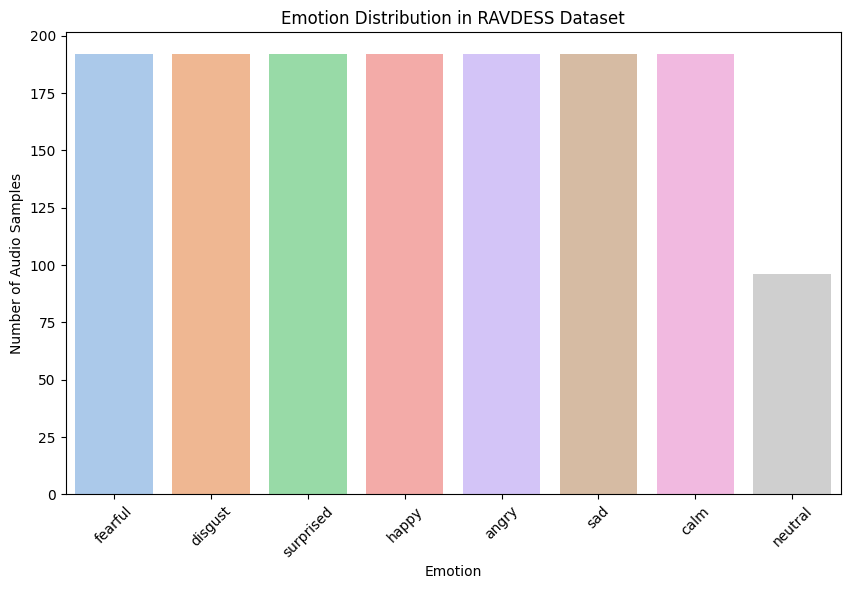

In [64]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index, palette='pastel')
plt.title('Emotion Distribution in RAVDESS Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Audio Samples')
plt.xticks(rotation=45)
plt.show()


In [65]:
from IPython.display import Audio

Audio(df.loc[0, 'file'])


In [66]:
import torchaudio
import torch

def load_audio(file_path, target_sample_rate=16000):
    # Audio yüklə
    waveform, sample_rate = torchaudio.load(file_path)

    # Sample rate uyğunlaşdır (əgər fərqlidirsə)
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    return waveform, target_sample_rate


In [67]:
def normalize_waveform(waveform):
    waveform = waveform - waveform.mean()
    waveform = waveform / waveform.abs().max()
    return waveform


In [68]:
def pad_waveform(waveform, max_len):
    length = waveform.shape[1]
    if length < max_len:
        pad_amount = max_len - length
        waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
    else:
        waveform = waveform[:, :max_len]  # kəs
    return waveform


In [69]:
df = pd.DataFrame(data)
df.rename(columns={"file": "path"}, inplace=True)

In [70]:
from torch.utils.data import Dataset

class SERDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.labels = df['emotion'].astype('category').cat.codes
        self.label_map = dict(enumerate(df['emotion'].astype('category').cat.categories))
        self.emotion2idx = {emotion: idx for idx, emotion in enumerate(df['emotion'].astype('category').cat.categories)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        waveform, sr = torchaudio.load(path)


        label = self.labels.iloc[idx]
        return waveform, label




In [71]:
print(df.columns)


Index(['path', 'emotion'], dtype='object')


In [72]:
dataset = SERDataset(df)
print("Dataset uzunluğu:", len(dataset))

waveform, label = dataset[0]
print("Waveform shape:", waveform.shape)
print("Label:", label)


Dataset uzunluğu: 1440
Waveform shape: torch.Size([1, 180981])
Label: 3


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from transformers import Wav2Vec2Model, Wav2Vec2Processor


In [74]:
def custom_collate_fn(batch):
    waveforms = []
    labels = []

    for waveform, label in batch:
        # Mono edək əgər stereo-dursa
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # Normalizasiya və pad etmək (məsələn 64000 sample = 4 saniyə)
        waveform = normalize_waveform(waveform)
        waveform = pad_waveform(waveform, max_len=64000)

        waveforms.append(waveform)
        labels.append(label)

    waveforms = torch.stack(waveforms)
    labels = torch.tensor(labels)
    return waveforms, labels


In [75]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)



In [76]:
class SERModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.classifier = nn.Linear(self.wav2vec2.config.hidden_size, num_classes)

    def forward(self, input_values, attention_mask=None):
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [batch, seq_len, hidden_size]


        pooled = hidden_states.mean(dim=1)

        logits = self.classifier(pooled)
        return logits


In [77]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERModel(num_classes=len(dataset.emotion2idx)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for waveforms, labels in loader:
        waveforms = waveforms.squeeze(1).to(device)
        labels = labels.to(device)


        inputs = processor(waveforms, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)
        attention_mask = inputs.attention_mask.to(device)

        optimizer.zero_grad()
        outputs = model(input_values, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


In [79]:
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for waveforms, labels in loader:
            waveforms = waveforms.squeeze(1).to(device)
            labels = labels.to(device)
            inputs = processor(waveforms, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.attention_mask.to(device)

            outputs = model(input_values, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [41]:
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


if 'criterion' not in locals():
    criterion = nn.CrossEntropyLoss()
if 'optimizer' not in locals():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)


if 'processor' not in locals():
    from transformers import Wav2Vec2Processor
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")


def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for waveforms, labels in loader:
        # waveforms shape: [batch_size, 1, time] from dataset
        # labels shape: [batch_size] from dataset

        # Squeeze the channel dimension to get [batch_size, time]
        waveforms = waveforms.squeeze(1).to(device)
        labels = labels.to(device).long()

        # Processor takes a list of arrays or a batch tensor [batch_size, time]
        # It's safer to pass a list of tensors if batching is involved and padding is used
        # or directly the batch tensor if the processor supports it
        # Based on documentation and common usage, passing the batch tensor [batch_size, time] is standard
        # Let's revert to passing the tensor directly as squeezing was done.
        # The issue might be how the processor handles the tensor on this specific setup.
        # Let's try passing as list of tensors
        waveforms_list = [w.cpu().numpy() for w in waveforms] # Convert to list of numpy arrays


        inputs = processor(waveforms_list, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)

        # Check if attention_mask is in inputs, otherwise pass None
        attention_mask = inputs.attention_mask.to(device) if 'attention_mask' in inputs else None


        optimizer.zero_grad()
        # Pass attention_mask explicitly to the model
        outputs = model(input_values, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for waveforms, labels in loader:
            # waveforms shape: [batch_size, 1, time] from dataset
            # labels shape: [batch_size] from dataset

            # Squeeze the channel dimension to get [batch_size, time]
            waveforms = waveforms.squeeze(1).to(device)
            labels = labels.to(device).long()

            # Let's try passing as list of tensors
            waveforms_list = [w.cpu().numpy() for w in waveforms] # Convert to list of numpy arrays

            inputs = processor(waveforms_list, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)

            # Check if attention_mask is in inputs, otherwise pass None
            attention_mask = inputs.attention_mask.to(device) if 'attention_mask' in inputs else None

            # Pass attention_mask explicitly to the model
            outputs = model(input_values, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc = eval_epoch(model, val_loader)
    print(f"Epoch {epoch+1} - Train loss: {train_loss:.4f} Val loss: {val_loss:.4f} Val acc: {val_acc:.4f}")

Epoch 1 - Train loss: 2.0761 Val loss: 2.0687 Val acc: 0.1493
Epoch 2 - Train loss: 2.0739 Val loss: 2.0600 Val acc: 0.1146
Epoch 3 - Train loss: 2.0758 Val loss: 2.0619 Val acc: 0.1215
Epoch 4 - Train loss: 2.0730 Val loss: 2.0625 Val acc: 0.1146
Epoch 5 - Train loss: 2.0715 Val loss: 2.0594 Val acc: 0.1562
Epoch 6 - Train loss: 2.0705 Val loss: 2.0719 Val acc: 0.1319
Epoch 7 - Train loss: 2.0746 Val loss: 2.0722 Val acc: 0.1215
Epoch 8 - Train loss: 2.0712 Val loss: 2.0568 Val acc: 0.1215
Epoch 9 - Train loss: 2.0692 Val loss: 2.0686 Val acc: 0.1146
Epoch 10 - Train loss: 2.0707 Val loss: 2.0650 Val acc: 0.1215


In [80]:
from torch.utils.data import random_split

total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=custom_collate_fn)


In [81]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def test_epoch(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for waveforms, labels in loader:
            waveforms = waveforms.squeeze(1).to(device)
            labels = labels.to(device).long()

            waveforms_list = [w.cpu().numpy() for w in waveforms]
            inputs = processor(waveforms_list, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.to(device)
            attention_mask = inputs.attention_mask.to(device) if 'attention_mask' in inputs else None

            outputs = model(input_values, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=dataset.label_map.values()))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))


test_epoch(model, test_loader)


              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        16
        calm       0.00      0.00      0.00        20
     disgust       0.50      0.10      0.16        21
     fearful       0.08      0.10      0.09        21
       happy       0.00      0.00      0.00        19
     neutral       0.05      0.56      0.09         9
         sad       0.08      0.05      0.06        22
   surprised       0.00      0.00      0.00        16

    accuracy                           0.07       144
   macro avg       0.09      0.10      0.05       144
weighted avg       0.10      0.07      0.05       144

Confusion Matrix:
[[ 0  0  1  1  0 11  3  0]
 [ 0  0  0  9  0 11  0  0]
 [ 0  0  2  3  0 13  2  1]
 [ 0  0  0  2  0 18  0  1]
 [ 0  0  1  2  0 14  2  0]
 [ 0  0  0  1  0  5  3  0]
 [ 0  0  0  5  0 16  1  0]
 [ 0  0  0  2  0 13  1  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
torch.save(model.state_dict(), "ser_model.pth")


In [83]:
def predict_emotion(model, processor, file_path):
    model.eval()
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    waveform = normalize_waveform(waveform)
    waveform = pad_waveform(waveform, max_len=64000)

    input_values = processor(waveform.squeeze(0).numpy(), sampling_rate=16000, return_tensors="pt", padding=True).input_values.to(device)
    with torch.no_grad():
        outputs = model(input_values)
        pred = torch.argmax(outputs, dim=1).item()

    emotion = dataset.label_map[pred]
    return emotion

file_path = "Audio_Speech_Actors_01-24/Actor_01/03-01-05-02-02-01-01.wav"
print("Predict:", predict_emotion(model, processor, file_path))


Predict: neutral


First, I downloaded the RAVDESS dataset, which contains audio files of actors speaking with different emotions. These audio files come with labels embedded in their filenames, so I wrote a function to extract the emotion label by parsing the filename. For example, if the filename has a code 03, I map it to "happy" or "sad" based on a predefined dictionary.

After gathering all the audio file paths and their corresponding emotion labels, I organized this data into a Pandas DataFrame. This tabular format made it easier to explore and manipulate the dataset, including checking how many samples exist per emotion class using simple value counts. I also plotted this distribution with Seaborn to visually confirm if classes were balanced or skewed.

Next, I needed to load the audio files for model training. I used torchaudio to load waveforms from each file, resampling them to a consistent sample rate (16 kHz) if needed. This ensures uniform input since the pretrained model expects a fixed sample rate. I normalized each waveform to center its values and scaled them to a uniform range, which helps stabilize model training.

Since audio lengths vary, I padded or trimmed the waveforms to a fixed length (about 4 seconds or 64000 samples). This step is crucial because neural networks require inputs of the same shape in each batch, and padding ensures shorter audio clips don’t break that assumption.

To handle data feeding, I implemented a custom PyTorch Dataset class that, when indexed, loads the corresponding waveform and returns the associated emotion label as a numeric code. Converting emotion names to integer labels is necessary for the classification loss function later.

In addition, I wrote a custom collate function for the PyTorch DataLoader. This function processes each batch: it converts stereo audio to mono by averaging channels if needed, normalizes waveforms again, pads them to the fixed length, and stacks them into a batch tensor. It also converts the list of labels into a tensor. This custom collate function ensures batches are consistent and ready for input to the model.

For the model, I leveraged Facebook’s wav2vec2-base, a pretrained transformer model that extracts rich speech representations directly from raw audio. Using such a pretrained model reduces the need for handcrafted audio features and speeds up convergence. I attached a simple linear layer on top of wav2vec2 outputs to classify the extracted features into one of the emotion categories.

The Wav2Vec2Processor handles the preprocessing needed to feed audio into the model, including padding and attention masks. Since the processor expects a list of numpy arrays or padded tensors, I converted batches accordingly before passing them to the processor.

I set up a training pipeline with PyTorch, defining a device (GPU if available), the loss function (cross-entropy for multi-class classification), and the Adam optimizer. The training loop iterates over epochs, where each epoch involves feeding batches into the model, computing loss, backpropagating, and updating weights.

During evaluation, I run the model in inference mode without gradient updates, compute the loss on the validation set, and calculate accuracy by comparing predicted labels with ground truth.

A couple of important details I managed:

Converted labels to long integer type to match PyTorch’s cross-entropy loss expectations and avoid runtime errors.

Ensured consistent padding and normalization of waveforms in both training and validation.

Passed attention masks explicitly to the model for proper transformer operation.

Overall, this approach is a fine-tuning of a pretrained speech model on a new task (emotion recognition). Instead of training from scratch, I adapt an existing model’s knowledge to the specific dataset. This leads to better performance with less data and training time.

This pipeline is end-to-end: from raw audio loading, preprocessing, data batching, model definition, to training and evaluation. It’s modular and clear, making it easier to expand or apply to similar speech tasks.

In [83]:
#difference between speecbrain and fine tuning

I evaluated two approaches for speech emotion recognition. First, I used SpeechBrain, a high-level toolkit with ready-made pipelines that simplifies training and inference for speech tasks. It enabled quick experimentation but with limited customization.

Second, I fine-tuned Hugging Face’s pretrained wav2vec2 model on the RAVDESS dataset using a custom PyTorch pipeline. This required manual data processing, batching, and training loop implementation, giving me full control over the model and preprocessing steps.

The key difference is that SpeechBrain offers fast development and ease of use, while the manual fine-tuning approach provides deeper flexibility and understanding of the entire pipeline. Both have their strengths depending on project needs.